In [2]:
from utils.ETC import *
from utils.Plot import *
from sgp4.api import WGS72
from itertools import tee
from sgp4.ext import invjday
from itertools import islice
import pandas as pd

In [3]:
# 지구반지름
earth_radius = 6378.137
# 라디안에서 degree로 변환
rad2deg = 180.0 / np.pi

altitude_df = pd.DataFrame(columns=['Altitude'])
velocity_df = pd.DataFrame(columns=['Velocity'])
apogees_df = pd.DataFrame(columns=['Apogee'])
perigees_df = pd.DataFrame(columns=['Perigee'])
inclinations_df = pd.DataFrame(columns=['Inclination'])
eccentricities_df = pd.DataFrame(columns=['Eccentricity'])
RAANs_df = pd.DataFrame(columns=['RAAN'])

# 만리경 txt 파일 불러오기

In [4]:
file_path = 'Database/MALLIGYONG_TLE.txt'

def read_in_chunks(file_path, chunk_size=3):
    with open(file_path, 'r', encoding='utf-8') as file:
        while True:
            # 파일에서 chunk_size만큼 읽기
            lines = list(islice(file, chunk_size))
            if not lines:
                break
            yield lines

chunk_lst = []
for chunk in read_in_chunks(file_path, 3):
    chunk_dict = {}
    chunk_dict['name'] = chunk[0].strip()
    chunk_dict['firstLine'] = chunk[1].strip()
    chunk_dict['secondLine'] = chunk[2].strip()
    chunk_lst.append(chunk_dict)

# TLE 사이 시간차이를 diff_lst 에 저장

In [5]:
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [6]:
diff_lst = []
delete_lst=[]
for i, (current_dict, next_dict) in enumerate(pairwise(chunk_lst)):
    satellite = Satrec.twoline2rv(current_dict["firstLine"], current_dict["secondLine"])

    # 위성 epoch의 정수부분
    current_integer = satellite.jdsatepoch
    # 위성 epoch의 소수부분
    current_decimal = satellite.jdsatepochF

    epochdatetime = invjday(current_integer + current_decimal)

    print(
        f'{epochdatetime[0]}-{epochdatetime[1]}-{epochdatetime[2]} {epochdatetime[3]}:{epochdatetime[4]}:{epochdatetime[5]}')

    satellite2 = Satrec.twoline2rv(next_dict["firstLine"], next_dict["secondLine"])

    # 위성 epoch의 정수부분
    next_integer = satellite2.jdsatepoch
    # 위성 epoch의 소수부분
    next_decimal = satellite2.jdsatepochF

    epochdatetime2 = invjday(next_integer + next_decimal)
    
    if epochdatetime == epochdatetime2:
        delete_lst.append(i)
        continue

    diff = (next_integer + next_decimal) - (current_integer + current_decimal)
    diff_lst.append(diff)

2023-11-22 0:14:26.541869938640914
2023-11-22 3:57:45.3113186362079
2023-11-22 20:45:54.27793264415773
2023-11-22 22:51:26.794066429405532
2023-11-23 5:11:1.6388306024363861
2023-11-23 10:58:26.825946271686874
2023-11-23 14:7:54.01430010822328
2023-11-23 20:26:48.340877294807754
2023-11-23 22:1:31.905704140930496
2023-11-24 2:45:42.58022904422792
2023-11-24 12:14:3.8204079869082794
2023-11-24 13:48:47.349789440899215
2023-11-24 20:7:41.39211952713045
2023-11-24 21:42:24.88263577249559
2023-11-25 4:1:18.82128506925615
2023-11-25 5:36:2.289310992031418
2023-11-25 16:39:6.421256661682449
2023-11-25 22:57:59.993583262234054
2023-11-26 5:16:53.54772448566469
2023-11-26 14:45:13.650915026932083
2023-11-26 16:19:56.99281007078203
2023-11-26 16:19:56.99281007078203
2023-11-27 3:23:0.17521351602586366
2023-11-27 6:32:26.748402714996658
2023-11-27 14:26:3.1519854071429596
2023-11-27 16:0:46.41522467163118
2023-11-27 16:0:46.41522467163118
2023-11-28 3:3:49.154419899254165
2023-11-28 6:13:15.6100

In [7]:
# 시간차이를 통해 몇 번 반복해야 하는지 리스트로 저장
multiplied_numbers = [int(x * 24) + 1 for x in diff_lst]
multiplied_numbers.append(24)

# TLE 중에서 똑같은 시간대에 중복되는 TLE 제거

In [8]:
# 인덱스를 내림차순으로 정렬
delete_lst.sort(reverse=True)

# 각 인덱스의 요소를 제거
for index in delete_lst:
    if 0 <= index < len(chunk_lst):  # 인덱스가 범위를 벗어나지 않도록 확인
        del chunk_lst[index]

# 시간대 중복계산은 내부에서 해결

In [9]:
a=0
for i, tles_dict in enumerate(chunk_lst):
    satellite = Satrec.twoline2rv(tles_dict["firstLine"], tles_dict["secondLine"])

    # 위성 epoch의 정수부분
    integer = satellite.jdsatepoch
    # 위성 epoch의 소수부분
    decimal = satellite.jdsatepochF

    epochdatetime = invjday(integer + decimal)
    day_date = f'{epochdatetime[0]}-{epochdatetime[1]}-{epochdatetime[2]}'
    temp_date = f'{epochdatetime[0]}-{epochdatetime[1]}-{epochdatetime[2]} {epochdatetime[3]}:00:00'
    print(
        f'{epochdatetime[0]}-{epochdatetime[1]}-{epochdatetime[2]} {epochdatetime[3]}:{epochdatetime[4]}:{epochdatetime[5]}')

    iteral = 0
    
    for j in range(multiplied_numbers[i]):
        try:
            if last_date == temp_date:
                print('시간대 중복 계산을 피하는 부분')
                last_date = None
                continue
        except:
            pass

        fr = decimal + j / 24

        epochdatetime = invjday(integer + fr)
        date = f'{epochdatetime[0]}-{epochdatetime[1]}-{epochdatetime[2]} {epochdatetime[3]}:00:00'
        print(date)
        e, r, v = satellite.sgp4(integer, fr)

        altitude = (r[0] ** 2 + r[1] ** 2 + r[2] ** 2) ** 0.5
        velocity = (v[0] ** 2 + v[1] ** 2 + v[2] ** 2) ** 0.5

        apogees_df.loc[date] = satellite.alta * earth_radius
        perigees_df.loc[date] = satellite.altp * earth_radius
        inclinations_df.loc[date] = satellite.inclo * rad2deg
        eccentricities_df.loc[date] = satellite.ecco
        RAANs_df.loc[date] = satellite.nodeo

        velocity_df.loc[date] = velocity
        altitude_df.loc[date] = altitude - earth_radius

        iteral += 1

    last_date = date
    if iteral == 0:
        print('TLE 사이 시간 간격이 너무 좁아서 속도와 변위가 계산이 안되는 경우가 있는데 이 경우는 무시해도 nan값 안생김')
        a+=1
        iteral = 1

perigees_df.index = pd.to_datetime(perigees_df.index)
apogees_df.index = pd.to_datetime(apogees_df.index)
velocity_df.index = pd.to_datetime(velocity_df.index)
altitude_df.index = pd.to_datetime(altitude_df.index)
inclinations_df.index = pd.to_datetime(inclinations_df.index)
eccentricities_df.index = pd.to_datetime(eccentricities_df.index)
RAANs_df.index = pd.to_datetime(RAANs_df.index)

2023-11-22 0:14:26.541869938640914
2023-11-22 0:00:00
2023-11-22 1:00:00
2023-11-22 2:00:00
2023-11-22 3:00:00
2023-11-22 3:57:45.3113186362079
시간대 중복 계산을 피하는 부분
2023-11-22 4:00:00
2023-11-22 5:00:00
2023-11-22 6:00:00
2023-11-22 7:00:00
2023-11-22 8:00:00
2023-11-22 9:00:00
2023-11-22 10:00:00
2023-11-22 11:00:00
2023-11-22 12:00:00
2023-11-22 13:00:00
2023-11-22 14:00:00
2023-11-22 15:00:00
2023-11-22 16:00:00
2023-11-22 17:00:00
2023-11-22 18:00:00
2023-11-22 19:00:00
2023-11-22 20:45:54.27793264415773
2023-11-22 20:00:00
2023-11-22 21:00:00
2023-11-22 22:00:00
2023-11-22 22:51:26.794066429405532
시간대 중복 계산을 피하는 부분
2023-11-22 23:00:00
2023-11-23 0:00:00
2023-11-23 1:00:00
2023-11-23 2:00:00
2023-11-23 3:00:00
2023-11-23 4:00:00
2023-11-23 5:11:1.6388306024363861
2023-11-23 5:00:00
2023-11-23 6:00:00
2023-11-23 7:00:00
2023-11-23 8:00:00
2023-11-23 9:00:00
2023-11-23 10:00:00
2023-11-23 10:58:26.825946271686874
시간대 중복 계산을 피하는 부분
2023-11-23 11:00:00
2023-11-23 12:00:00
2023-11-23 13:00

# 그래프 출력

In [10]:
velocity_df = velocity_df.resample('D').mean()

In [11]:
altitude_df = altitude_df.resample('D').mean()

In [14]:
apogees_df

,Apogee
2023-11-22 00:00:00,509.278908
2023-11-22 01:00:00,509.278908
2023-11-22 02:00:00,509.278908
2023-11-22 03:00:00,509.278908
2023-11-22 04:00:00,509.119343
...,...
2024-07-04 17:00:00,501.342243
2024-07-04 18:00:00,501.342243
2024-07-04 19:00:00,501.342243
2024-07-04 20:00:00,501.342243


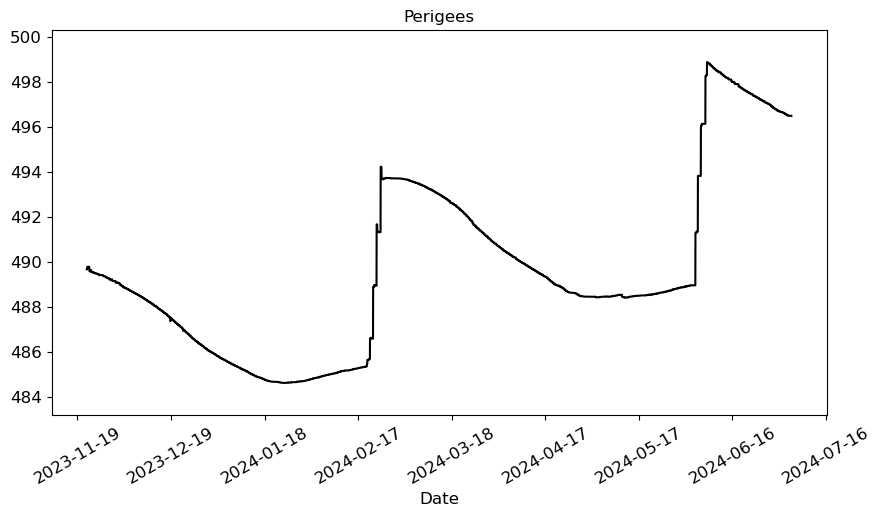

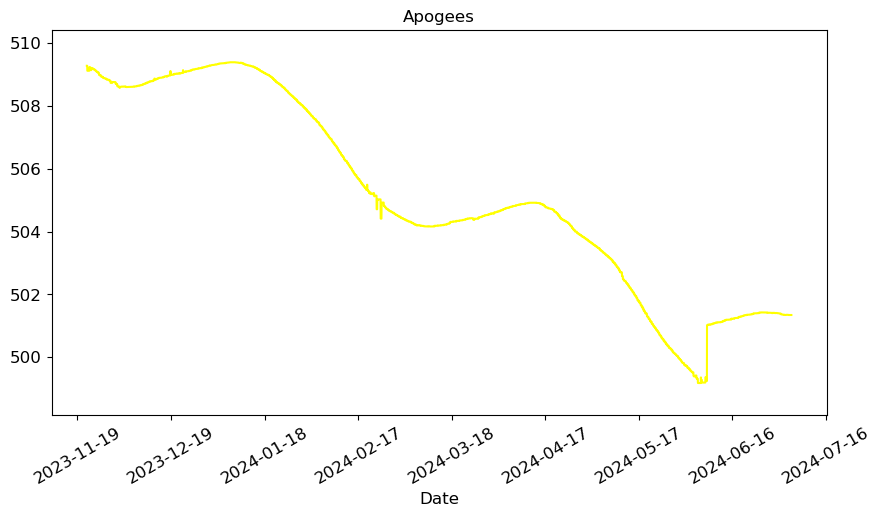

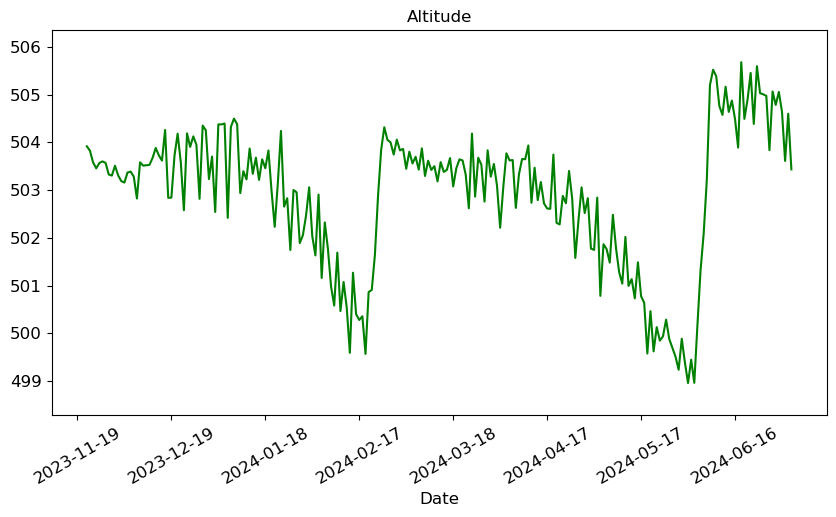

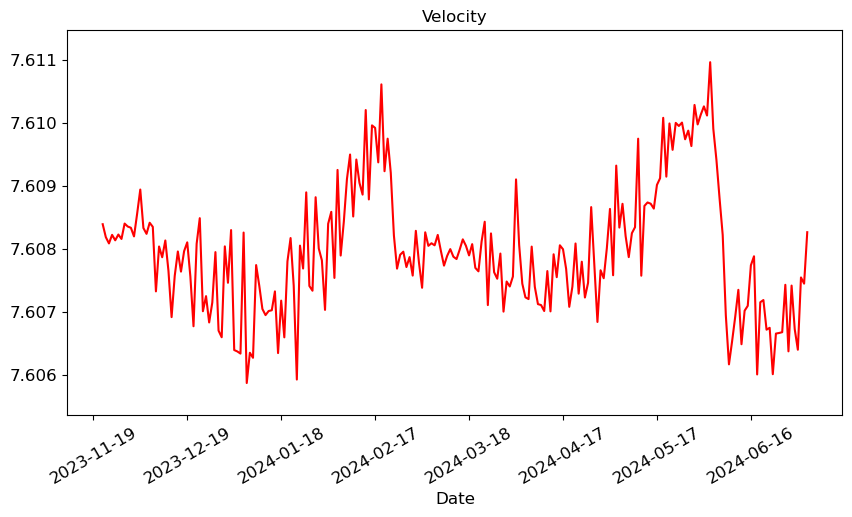

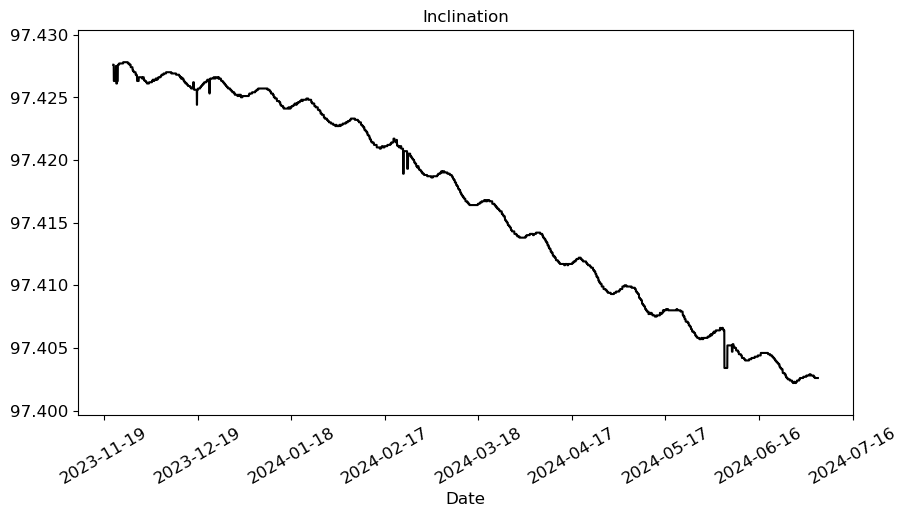

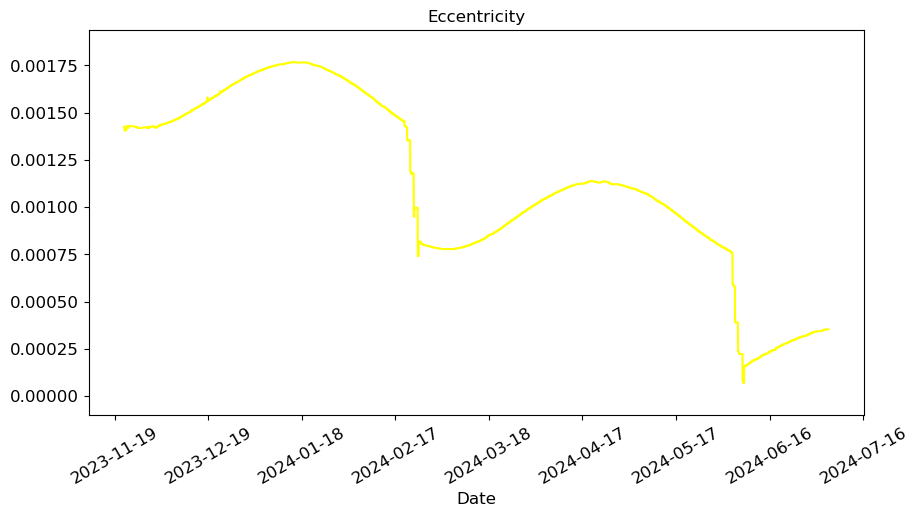

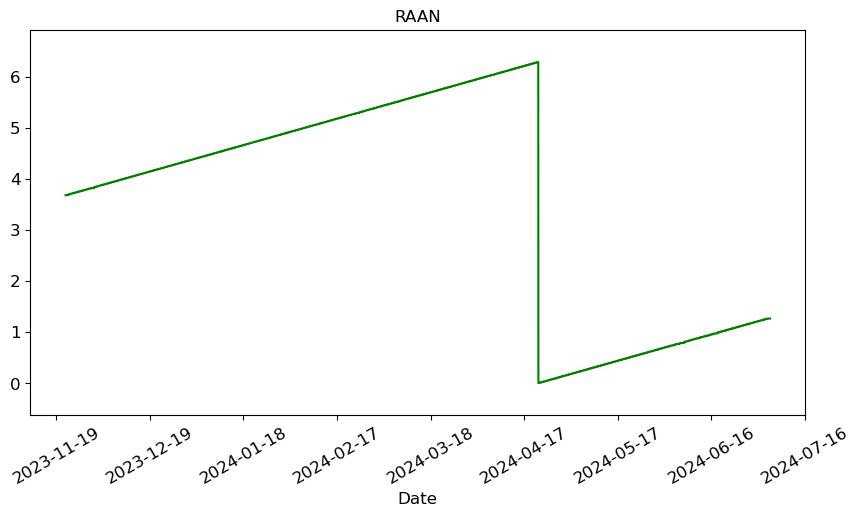

In [11]:
draw_graph(perigees_df, 'Perigees', '', "black")
draw_graph(apogees_df, 'Apogees', '', "Yellow")
draw_graph(altitude_df, 'Altitude', '', "green")
draw_graph(velocity_df, 'Velocity', '', "Red")
draw_graph(inclinations_df, 'Inclination', '', "Black")
draw_graph(eccentricities_df, 'Eccentricity', '', "Yellow")
draw_graph(RAANs_df, 'RAAN', '', "Green")